<a href="https://colab.research.google.com/github/splevine/harnessing-nlp-cx-demo/blob/main/notebooks/SetFit_Train_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SetFit and W&B

https://github.com/huggingface/setfit

https://huggingface.co/docs/setfit/index

## Set-Up

## Installs

In [ ]:
!pip install setfit
!pip install wandb
!pip install umap-learn

## Imports

In [ ]:
import json
import numpy as np
import pandas as pd
import wandb

import torch
from sentence_transformers import SentenceTransformer
from setfit import TrainingArguments, Trainer, SetFitModel
from datasets import load_dataset, Dataset, ClassLabel

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime

import umap
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import colorsys

# ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import logging
logger = logging.getLogger(__name__)

In [ ]:
!nvidia-smi

Thu Mar 21 23:23:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Functions

In [ ]:
def log_dataset_to_wandb(df, dataset_name):
  artifact = wandb.Artifact(dataset_name, type='dataset')
  data_table = wandb.Table(data=df)
  artifact.add(data_table, dataset_name)
  wandb.log_artifact(artifact)

# save model
def log_model_to_wandb(model_directory_name, artifact_name='demo_model'):
  artifact = wandb.Artifact(artifact_name, type='model')
  artifact.add_dir(model_directory_name)
  wandb.log_artifact(artifact)

In [ ]:
def create_mapping_dicts(label_name_col: str, df: pd.DataFrame, config_path: str) -> tuple:
  """Sort the unique label names alphabetically, assign them to an id, create config, save mapping dicts to config file"""
  label_names = sorted(df[label_name_col].unique())

  # Create the mapping dictionaries
  id2label = {i: label_names[i] for i in range(len(label_names))}
  label2id = {label_names[i]: i for i in range(len(label_names))}

  config = {"id_to_label": id2label, "label_to_id": label2id}

  # Save the id-to-label mapping dictionary as a JSON file
  try:
      with open(config_path, 'w') as handle:
          json.dump(config, handle, indent=2)
          logger.info(f"Saved config file to {config_path}")
  except Exception as e:
      logger.error(f"Error saving config file: {e}")

  return id2label, label2id

In [ ]:
def get_dataframe_predictions(model, df, id2label, text_column):
    df.index = range(len(df))
    df[text_column] = df[text_column].astype(str)
    probabilities = list(model.predict_proba(df[text_column], as_numpy=True))
    df['probs'] = probabilities
    df['predicted_id'] = df['probs'].apply(np.argmax)
    df['prediction'] = df['predicted_id'].map(id2label)
    df['max_probability'] = df['probs'].apply(max)
    return df

## 📄 **Data**

In [ ]:
%cd drive/MyDrive/DataHour/demo/

/content/drive/MyDrive/DataHour/demo


In [ ]:
!ls data

banking.csv	dialogues.jsonl       test_banking.csv	     train_banking.csv
banking.gsheet	prepared_banking.csv  test-utterances.jsonl


In [ ]:
## save dataframe to csv
task_name = "banking_demo"
data_version = "v1"

In [ ]:
df = pd.read_csv("data/train_banking.csv", index_col=0)

In [ ]:
df.intents.nunique()

29

In [ ]:
df.intents.value_counts()

CheckAccountBalance         251
InternalFundsTransfer       139
ExternalWireTransfer        124
FindBranch                  120
DisputeCharge               108
FindATM                      92
OpenBankingAccount           92
ReportLostStolenCard         77
GetBranchHours               73
CloseBankAccount             65
UpdateStreetAddress          60
UpdateEmail                  35
CheckTransactionHistory      25
AskAboutTransferTime         24
UpdatePhoneNumber            23
ReportNotice                 23
SetUpOnlineBanking           23
GetBranchInfo                22
GetWithdrawalLimit           21
RequestNewCard               15
AskAboutCashDeposits         15
GetAccountInfo               14
CheckAccountInterestRate     11
AskAboutTransferFees         11
AskAboutCardArrival          10
OrderChecks                  10
OpenCreditCard                8
AskAboutATMFees               8
AskAboutCreditScore           4
Name: intents, dtype: int64

In [ ]:
# drop all rows with count less than 10
df = df.groupby('intents').filter(lambda x: len(x) > 10)

In [ ]:
df.head()

,dialogue_id,turn_id,speaker_role,utterance,dialogue_acts,intents
0,banking_0000,banking_0000_001,Customer,Yes I called earlier to see if you could see a...,['InformIntent'],CheckAccountBalance
1,banking_0000,banking_0000_039,Customer,Actually yes. Could you also give me the balan...,['InformIntent'],CheckAccountBalance
2,banking_0000,banking_0000_045,Customer,"OK, could you also tell me what the last depos...",['InformIntent'],CheckTransactionHistory
3,banking_0001,banking_0001_001,Customer,"yes, I need to change a email that I have on f...",['InformIntent'],UpdateEmail
4,banking_0002,banking_0002_001,Customer,yes. I've lost my phone last week on a trip to...,['InformIntent'],UpdatePhoneNumber


In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
config_path = "config.json"
label_name_col = "intents"
id2label, label2id = create_mapping_dicts(label_name_col, df, config_path)
df['labels'] = df[label_name_col].map(label2id)

In [ ]:
df.labels.nunique()

24

### Split into train and validation sets

### Simulate Few-Shot Learning

In [ ]:
# Initialize empty train and test dataframes
train_df = pd.DataFrame(columns=df.columns)
val_df = pd.DataFrame(columns=df.columns)

# Iterate over each label
for label in df['labels'].unique():
    # Select 4 samples for each label
    label_df = df[df['labels'] == label].head(4)

    # Concat selected samples to train_df
    train_df = pd.concat([train_df, label_df])

# Select remaining samples for test_df
val_df = df.drop(train_df.index)

# Optional: shuffle the dataframes
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# train_df, test_df = train_test_split(df, train_size=96, stratify=df["labels"], random_state=42)
train_df.intents.value_counts()

ExternalWireTransfer        4
GetBranchInfo               4
AskAboutTransferTime        4
FindATM                     4
GetAccountInfo              4
RequestNewCard              4
AskAboutCashDeposits        4
FindBranch                  4
CheckTransactionHistory     4
OpenBankingAccount          4
CheckAccountBalance         4
UpdateEmail                 4
InternalFundsTransfer       4
UpdateStreetAddress         4
ReportLostStolenCard        4
CheckAccountInterestRate    4
UpdatePhoneNumber           4
DisputeCharge               4
GetWithdrawalLimit          4
ReportNotice                4
AskAboutTransferFees        4
SetUpOnlineBanking          4
CloseBankAccount            4
GetBranchHours              4
Name: intents, dtype: int64

In [ ]:
train_df.head()

,dialogue_id,turn_id,speaker_role,utterance,dialogue_acts,intents,labels
0,banking_0022,banking_0022_001,Customer,Yeah I need to make a wire transfer.,['InformIntent'],ExternalWireTransfer,8
1,banking_0238,banking_0238_017,Customer,OK. Phone number please.,[],GetBranchInfo,13
2,banking_0083,banking_0083_013,Customer,That is correct. can you tell me how soon that...,['InformIntent'],AskAboutTransferTime,2
3,banking_0028,banking_0028_001,Customer,Yes good morning. my name is John Meadows and ...,['InformIntent'],FindATM,9
4,banking_0081,banking_0081_031,Customer,Do I need to be home? And where where are you ...,['InformIntent'],GetAccountInfo,11


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['dialogue_id', 'turn_id', 'speaker_role', 'utterance', 'dialogue_acts', 'intents', 'labels'],
    num_rows: 96
})

In [ ]:
val_dataset = Dataset.from_pandas(val_df)
val_dataset

Dataset({
    features: ['dialogue_id', 'turn_id', 'speaker_role', 'utterance', 'dialogue_acts', 'intents', 'labels'],
    num_rows: 1367
})

## SetFit

In [ ]:
# load model
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# calculate embeddings
train_embeddings = model.encode(train_dataset["utterance"])

## Visualize Embeddings

In [ ]:
def visualize_2d_umap(embeddings, df):
    umap_data = umap.UMAP(n_neighbors=15,
                          n_components=2,
                          min_dist=0.1,
                          metric='cosine').fit_transform(embeddings)

    umap_df = pd.DataFrame(umap_data, columns=['x', 'y'])
    umap_df['body'] = df['utterance']
    umap_df['label'] = df['intents']
    umap_df['preview'] = umap_df['body'].str[:60]

    fig = px.scatter(data_frame=umap_df,
                     x='x',
                     y='y',
                     color='label',
                     hover_data=['preview', 'label'],
                     title="Customer Messages in 2D")
    return fig


def visualize_3d_umap(embeddings, df):
    umap_data = umap.UMAP(n_neighbors=15,
                          n_components=3,
                          min_dist=0.1,
                          metric='cosine').fit_transform(embeddings)

    umap_df = pd.DataFrame(umap_data, columns=['x', 'y', 'z'])
    umap_df['body'] = df['utterance']
    umap_df['label'] = df['intents']
    umap_df['preview'] = umap_df['body'].str[:50]

    fig = px.scatter_3d(data_frame=umap_df,
                        x='x',
                        y='y',
                        z='z',
                        color='label',
                        opacity=0.7,
                        hover_data=['preview', 'label'],
                        title="Customer Messages in 3D")
    # fig.update_traces(marker_size=3)

    return fig

In [ ]:
visualize_2d_umap(train_embeddings, train_df)

In [ ]:
visualize_3d_umap(train_embeddings, train_df)

## Train Model

In [ ]:
args = TrainingArguments(
    batch_size=32,
    num_epochs=1,
    run_name="demo-1",
    report_to=["wandb", "tensorboard"]
    )

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    column_mapping={"labels":"label", "utterance":"text"}
)

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/96 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

***** Running training *****
  Num unique pairs = 8832
  Batch size = 32
  Num epochs = 1
  Total optimization steps = 276
wandb: Currently logged in as: splevine (loris-ai). Use `wandb login --relogin` to force relogin


Step,Training Loss


In [ ]:
trainer.evaluate(val_dataset)

Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.7768836869056328}

## Predictions on Training Dataset

In [ ]:
train_df = get_dataframe_predictions(model, train_df, id2label, text_column="utterance")

In [ ]:
train_df.columns

Index(['dialogue_id', 'turn_id', 'speaker_role', 'utterance', 'dialogue_acts',
       'intents', 'labels', 'probs', 'predicted_id', 'prediction',
       'max_probability'],
      dtype='object')

In [ ]:
train_df[["utterance", "intents", "prediction", "max_probability"]].head(10)

,utterance,intents,prediction,max_probability
0,Yeah I need to make a wire transfer.,ExternalWireTransfer,ExternalWireTransfer,0.800240
1,OK. Phone number please.,GetBranchInfo,GetBranchInfo,0.873629
2,That is correct. can you tell me how soon that...,AskAboutTransferTime,AskAboutTransferTime,0.900699
3,Yes good morning. my name is John Meadows and ...,FindATM,FindATM,0.888265
4,Do I need to be home? And where where are you ...,GetAccountInfo,GetAccountInfo,0.905313
5,OK and I have another question. can you see wh...,FindATM,FindATM,0.889657
6,I would like to go ahead. Can we can we lock t...,RequestNewCard,RequestNewCard,0.903369
7,No no but that ATM does it do cash deposit bec...,AskAboutCashDeposits,AskAboutCashDeposits,0.894072
8,I mean if there's one close I'd be willing to ...,FindBranch,FindBranch,0.899682
9,"OK, could you also tell me what the last depos...",CheckTransactionHistory,CheckTransactionHistory,0.894669


In [ ]:
train_embeddings_1_epoch = model.encode(train_df["utterance"].tolist())
visualize_2d_umap(train_embeddings_1_epoch, train_df)

In [ ]:
visualize_3d_umap(train_embeddings_1_epoch, train_df)

## Validation Set

In [ ]:
val_df = get_dataframe_predictions(model, val_df, id2label, text_column="utterance")

In [ ]:
val_df[["utterance", "intents", "prediction", "max_probability"]].head(10)

,utterance,intents,prediction,max_probability
0,And could you check the balance in my checking...,CheckAccountBalance,CheckAccountBalance,0.896576
1,"Do you see any transactions made on that card,...",CheckTransactionHistory,AskAboutCashDeposits,0.245966
2,I don't understand why there wouldn't have bee...,CheckAccountBalance,CheckAccountBalance,0.239091
3,Could you tell me what is I'm transferring I w...,CheckAccountBalance,InternalFundsTransfer,0.286462
4,Trying to figure out if my card is lost or sto...,ReportLostStolenCard,ReportLostStolenCard,0.698923
5,May I check my balance first?,CheckAccountBalance,CheckAccountBalance,0.849267
6,I have been looking through my statements. The...,DisputeCharge,GetAccountInfo,0.196650
7,"OK, great. And is the ATM hours the same as th...",GetBranchHours,GetBranchHours,0.818592
8,Yes there is. I would also like to open a savi...,OpenBankingAccount,OpenBankingAccount,0.825763
9,oh oh before we do that I do need to ask you. ...,CheckAccountBalance,CheckAccountBalance,0.379229


In [ ]:
print(classification_report(val_df["intents"], val_df["prediction"]))

                          precision    recall  f1-score   support

    AskAboutCashDeposits       0.62      0.73      0.67        11
    AskAboutTransferFees       0.50      1.00      0.67         7
    AskAboutTransferTime       0.83      1.00      0.91        20
     CheckAccountBalance       0.97      0.90      0.93       247
CheckAccountInterestRate       0.67      0.86      0.75         7
 CheckTransactionHistory       0.74      0.67      0.70        21
        CloseBankAccount       0.84      0.97      0.90        61
           DisputeCharge       0.94      0.81      0.87       104
    ExternalWireTransfer       0.63      0.62      0.63       120
                 FindATM       0.85      0.85      0.85        88
              FindBranch       0.73      0.64      0.68       116
          GetAccountInfo       0.09      0.10      0.10        10
          GetBranchHours       0.98      0.87      0.92        69
           GetBranchInfo       0.29      0.78      0.42        18
      Get

## Evaluation

In [ ]:
!ls data

banking.csv	dialogues.jsonl       test_banking.csv	     train_banking.csv
banking.gsheet	prepared_banking.csv  test-utterances.jsonl


In [ ]:
evaluation_df = pd.read_csv("data/test_banking.csv")

In [ ]:
evaluation_df = get_dataframe_predictions(model, evaluation_df, id2label, text_column="utterance")

In [ ]:
labels = sorted(evaluation_df["intents"].unique())

In [ ]:
print(classification_report(evaluation_df["intents"], evaluation_df["prediction"], labels=labels))

                         precision    recall  f1-score   support

   AskAboutCashDeposits       1.00      1.00      1.00        10
   AskAboutTransferTime       1.00      1.00      1.00        21
    CheckAccountBalance       0.97      1.00      0.98        30
CheckTransactionHistory       0.94      0.80      0.86        20
       CloseBankAccount       0.94      0.91      0.92        32
          DisputeCharge       1.00      0.94      0.97        32
   ExternalWireTransfer       0.59      0.65      0.62        26
                FindATM       0.87      1.00      0.93        26
             FindBranch       0.92      0.57      0.71        21
         GetBranchHours       1.00      0.90      0.95        21
     GetWithdrawalLimit       1.00      1.00      1.00        20
  InternalFundsTransfer       0.74      0.65      0.69        26
     OpenBankingAccount       1.00      0.90      0.95        21
   ReportLostStolenCard       1.00      0.90      0.95        21
     SetUpOnlineBanking 

In [ ]:
## create confusion matrix
cm = confusion_matrix(evaluation_df["intents"], evaluation_df["prediction"], labels=labels)

In [ ]:
def plot_confusion_matrix(cm, class_names, filename, chart_name=None):
    """
    Plot confusion matrix.

    Parameters:
        cm (ndarray): Confusion matrix.
        class_names (list): List of class names.
        chart_name (str): Name of the client.
        filename (str): File name to save the plot.
    """
    vmin = np.min(cm)
    vmax = np.max(cm)

    plt.figure(figsize=(10, 8))  # Adjust size of the plot

    # Create the heatmap with annotations
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', vmin=vmin, vmax=vmax, cbar=False, annot_kws={"fontsize": 12})

    # Customize the diagonal cells
    sns.heatmap(cm, annot=False, mask=np.eye(cm.shape[0]), cmap='OrRd', vmin=vmin, vmax=vmax, cbar=False, fmt='d')

    # Add class names as labels
    plt.xticks(np.arange(len(class_names))+0.5, class_names, rotation=45, ha='right', fontsize=12)
    plt.yticks(np.arange(len(class_names))+0.5, class_names, rotation=0, fontsize=12)

    # Add true labels with dynamically adjusted text color
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            cell_color = sns.color_palette('Blues', as_cmap=True)(cm[i, j] / vmax)  # Get heatmap color
            r, g, b = cell_color[:3]  # Extract RGB components
            h, s, v = colorsys.rgb_to_hsv(r, g, b)  # Convert RGB to HSV
            text_color = 'white' if v < 0.5 else 'black'  # Adjust text color based on background luminance
            plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color=text_color, fontsize=12,
                     bbox=dict(facecolor='none', edgecolor='none', pad=0, linewidth=0))

    plt.xlabel('Predicted label', fontsize=13)
    plt.ylabel('True label', fontsize=13)

    # if chart_name is None, set title string to "Confusion Matrix"
    title = "Confusion Matrix"
    if chart_name:
        title = f"{title} - {chart_name}"

    plt.title(title)
    plt.savefig(filename, bbox_inches="tight")
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

    plt.close()

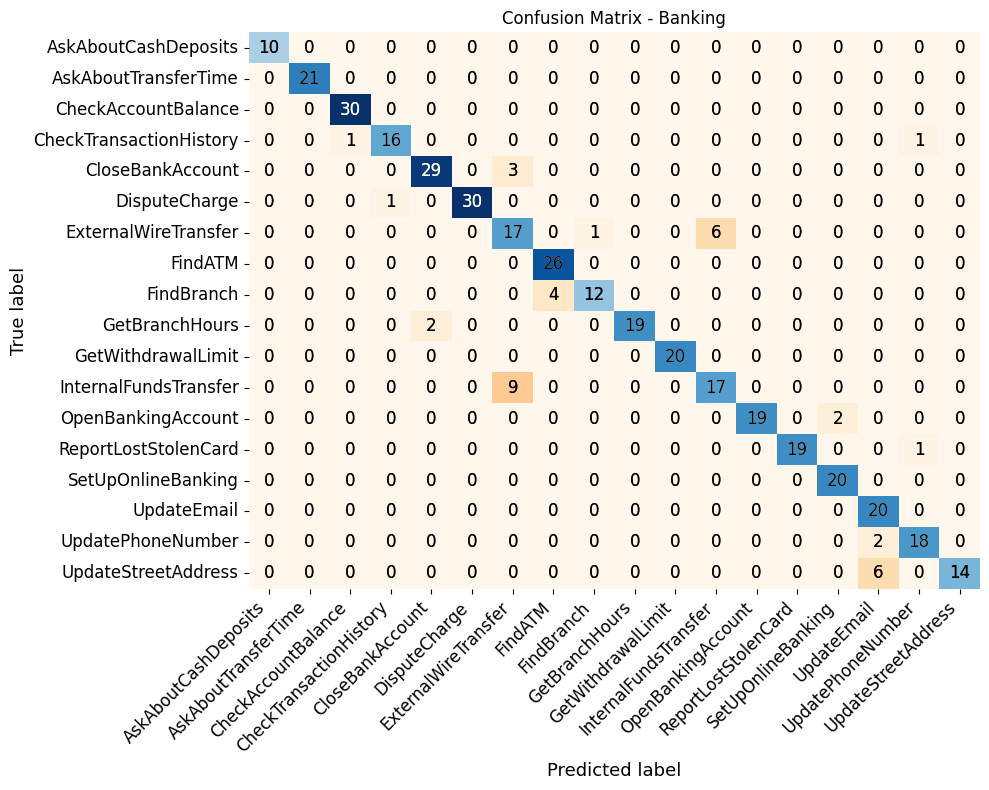

In [ ]:
plot_confusion_matrix(cm, labels, "confusion_matrix.png", chart_name="Banking")

## Visualizing Evaluation Set

### Before fine-tuning Sentence Transformer Model

In [ ]:
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"
initial_model = SetFitModel.from_pretrained(model_id)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# encode evaluation data
eval_initial_embeddings = initial_model.encode(evaluation_df["utterance"].tolist())

In [ ]:
visualize_2d_umap(eval_initial_embeddings, evaluation_df)

### After fine-tuning the sentence transformer model

In [ ]:
# encode evaluation data
eval_fit_embeddings = model.encode(evaluation_df["utterance"].tolist())

In [ ]:
visualize_2d_umap(eval_fit_embeddings, evaluation_df)

## Save to Weights and Biases

In [ ]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")

In [ ]:
current_time

'2024-03-21_23-57'

In [ ]:
# save model
model_directory_name = "models"
model_name = f"{task_name}_{current_time}"
model.save_pretrained(f"{model_directory_name}/{model_name}")

In [ ]:
with open(f"models/{model_name}/id2label.json", "w") as json_file:
  json.dump(id2label, json_file)

In [ ]:
log_model_to_wandb(f"models/{model_name}")

wandb: Adding directory to artifact (./models/banking_demo_2024-03-21_23-57)... Done. 1.8s


In [ ]:
log_dataset_to_wandb(train_df, "train_dataset")
log_dataset_to_wandb(evaluation_df, "evaluation_dataset")

In [ ]:
wandb.finish()

train/embedding_loss,█▂▁▂▁▁▂▁▁▁▁▁
train/epoch,▁▂▄▅▆▇█▁▂▄▅▆▇█
train/global_step,▁▂▄▅▆▇█▁▂▄▅▆▇█
train/learning_rate,▁█▆▅▃▂▁█▆▅▃▂
train/train_runtime,█▁
train/train_samples_per_second,▁█
train/train_steps_per_second,▁█
train/embedding_loss,0.0006
train/epoch,1.0
train/global_step,276
train/learning_rate,0.0
